In [1]:
# !pip install git+https://github.com/aleju/imgaug.git git+https://github.com/docPhil99/ImageDataAugmentor

In [2]:
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow_addons as tfa

from tensorflow.keras.preprocessing import image as tfk_image
from tensorflow.keras.preprocessing.image import ImageDataGenerator as tfk_ImageDataGenerator

#from tensorflow.python.keras.applications.efficientnet import EfficientNetB4 as tfk_BaseModel
#from tensorflow.python.keras.applications.efficientnet import preprocess_input as tfk_preprocess_input

#from tensorflow.python.keras.applications.inception_v3 import InceptionV3 as tfk_BaseModel
#from tensorflow.python.keras.applications.inception_v3 import preprocess_input as tfk_preprocess_input

#from tensorflow.python.keras.applications.resnet import ResNet50 as tfk_BaseModel
#from tensorflow.python.keras.applications.resnet import preprocess_input as tfk_preprocess_input

from tensorflow.python.keras.applications.xception import Xception as tfk_BaseModel
from tensorflow.python.keras.applications.xception import preprocess_input as tfk_preprocess_input

from ImageDataAugmentor.image_data_augmentor import ImageDataAugmentor
import albumentations as A

import datetime, os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set();
from PIL import Image, ImageEnhance

from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, log_loss, accuracy_score
from sklearn.preprocessing import OneHotEncoder

## Prepare Dataset

### Load and combine datasets

In [3]:
pd_shopee_train = pd.read_csv('shopee-product-detection-dataset/train.csv')
# pd_confusing_images = pd.read_csv('shopee-product-detection-dataset/confusing_images_2__mistake_ratio=0.9.csv')
pd_amazon_train = pd.read_csv('amazon-scraped-dataset/amazon.csv')

In [4]:
# uncomment to clean up the shopee dataset
# mask = ~pd_shopee_train.set_index('dir_filename').index.isin(pd_confusing_images.set_index('dir_filename').index)
# pd_shopee_train = pd_shopee_train.loc[mask].copy()

In [5]:
pd_shopee_train = pd_shopee_train.sample(frac=1).reset_index(drop=True)
pd_shopee_train['category']     = pd_shopee_train['category'].apply(lambda x : '{:02d}'.format(x))
pd_shopee_train['dir_filename'] = pd_shopee_train.apply(lambda x: 'shopee-product-detection-dataset/train/{}/{}'.format(x.category, x.filename), axis=1)

pd_amazon_train = pd_amazon_train.sample(frac=1).reset_index(drop=True)
pd_amazon_train['category']     = pd_amazon_train['category'].apply(lambda x : '{:02d}'.format(x))
pd_amazon_train['dir_filename'] = pd_amazon_train.apply(lambda x: 'amazon-scraped-dataset/{}/{}'.format(x.category, x.filename), axis=1)

In [6]:
pd_combined_dataset = pd_shopee_train.merge(pd_amazon_train, how='outer')
pd_combined_dataset.head()

,filename,category,dir_filename
0,dcc1e336342fc2da16c7b6411660adbf.jpg,19,shopee-product-detection-dataset/train/19/dcc1...
1,63927ec859cf4c6afe452841dafa47ef.jpg,39,shopee-product-detection-dataset/train/39/6392...
2,f2aef279f4e18fcafd2d52d3004dbcd9.jpg,09,shopee-product-detection-dataset/train/09/f2ae...
3,d2f4445f1adf32d10551f7978614af87.jpg,34,shopee-product-detection-dataset/train/34/d2f4...
4,3d87bc36a317e930b84013530643019f.jpg,29,shopee-product-detection-dataset/train/29/3d87...


In [7]:
assert(len(pd_shopee_train) + len(pd_amazon_train) == len(pd_combined_dataset))
assert(np.all(np.unique(pd_combined_dataset['category']) == 
              np.array(['{:02d}'.format(cat) for cat in range(42)])))

### Prepare data generators

In [8]:
input_shape = (256, 256, 3)
batch_size  = 64 #64+32

In [9]:
AUGMENTATIONS = A.Compose([
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.Rotate(),
    A.OneOf([
        A.RandomContrast(),
        A.RandomGamma(),
        A.RandomBrightness(),
    ], p = 0.3),
    A.OneOf([
        A.ElasticTransform(
            alpha = 120,
            sigma = 120 * 0.05,
            alpha_affine = 120 * 0.03
        ),
        A.GridDistortion(),
        A.OpticalDistortion(
            distort_limit = 2,
            shift_limit = 0.5
        ),
    ], p = 0.3),
    A.OneOf([
        A.Cutout(
            num_holes=4,
            max_h_size=64,
            max_w_size=64,
            #fill_mode="gaussian"
        ),
        A.GridDropout(
            ratio=0.25,
            holes_number_x=8,
            holes_number_y=8,
            #fill_mode="gaussian"
        ),
    ], p=1),
])

In [10]:
train_datagen = ImageDataAugmentor(
    preprocess_input=tfk_preprocess_input,
    validation_split=0.1,
    augment=AUGMENTATIONS,
)

train_generator = train_datagen.flow_from_dataframe(
    pd_shopee_train,
    directory='',
    x_col='dir_filename',
    y_col='category',
    target_size=input_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

val_generator = train_datagen.flow_from_dataframe(
    pd_shopee_train,
    directory='',
    x_col='dir_filename',
    y_col='category',
    target_size=input_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='validation'
)

Found 94554 validated image filenames belonging to 42 classes.
Found 10505 validated image filenames belonging to 42 classes.


### Check class distributions

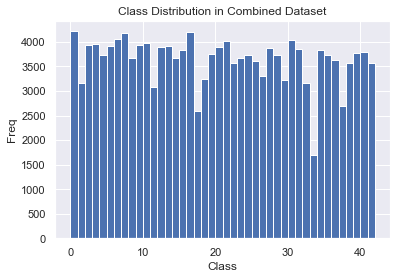

In [11]:
plt.title("Class Distribution in Combined Dataset")
plt.xlabel("Class")
plt.ylabel("Freq")
plt.hist(pd_combined_dataset['category'].astype(int), bins=np.arange(43));

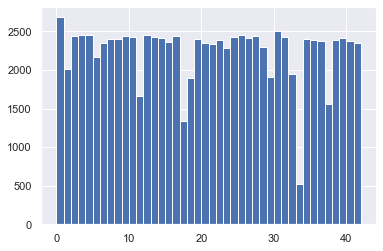

In [12]:
plt.hist(train_generator.classes, bins=np.arange(43));

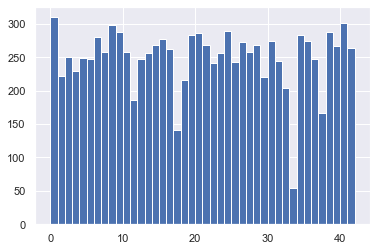

In [13]:
plt.hist(val_generator.classes, bins=np.arange(43));

### Calculate class weights

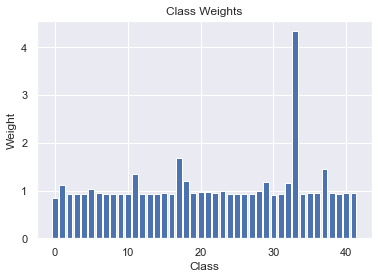

In [14]:
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(train_generator.classes),
                                                  train_generator.classes)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}
#for i in [0, 1, 2, 3, 20, 41]:
#    class_weights[i] = 1.25
plt.title("Class Weights")
plt.ylabel("Weight")
plt.xlabel("Class")
plt.bar(class_weights.keys(), class_weights.values());

## Prepare Model

In [15]:
base_model = tfk_BaseModel(input_shape=input_shape, weights='imagenet', include_top=False)

In [16]:
TYPE = 2
if TYPE == 1:
    for layer in base_model.layers[:-18]:
        layer.trainable = False
    model = tfk.Sequential([
        base_model,
        tfk.layers.GlobalMaxPooling2D(),
        tfk.layers.Dense(512, activation='relu'),
        tfk.layers.Dense(128, activation='relu'),
        tfk.layers.Dense(42, activation='softmax', name='output_layer'),
    ])
elif TYPE == 2:
    model = tfk.Sequential([
        base_model,
        tfk.layers.GlobalMaxPooling2D(),
        tfk.layers.Dropout(rate=0.2),
        tfk.layers.Dense(42, activation='softmax', name='output_layer'),
    ])
elif TYPE == 3:
    for layer in base_model.layers[:-len(base_model.layers)//5]:
        layer.trainable = False
    model = tfk.Sequential([
        base_model,
        tfk.layers.GlobalMaxPooling2D(),
        tfk.layers.Dropout(rate=0.2),
        tfk.layers.Dense(42, activation='softmax', name='output_layer'),
    ])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
output_layer (Dense)         (None, 42)                86058     
Total params: 20,947,538
Trainable params: 20,893,010
Non-trainable params: 54,528
_________________________________________________________________


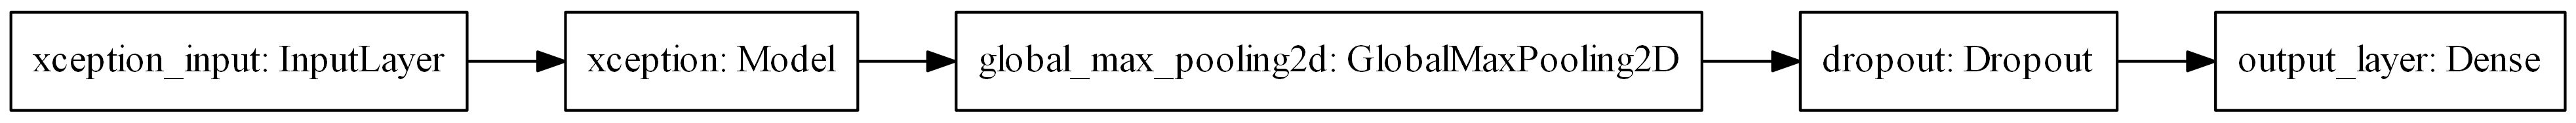

In [18]:
tfk.utils.plot_model(model, rankdir='LR', dpi=300, show_shapes=False)

In [19]:
# model.save('model_aug_full_4.h5')

## Train Top Layers of Model

### Load model

In [20]:
# model = tfk.models.load_model('model_aug_full_cleaner_19.h5')

### Prepare callbacks

In [21]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=10,
    min_lr=1e-7
)

early_stop = tfk.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True
)

log_dir = os.path.join(".model_files/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

checkpoint = tfk.callbacks.ModelCheckpoint(
    filepath = log_dir + '/ckpt/',
    save_freq ='epoch',
    save_best_only=True,
    monitor='val_loss'
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=0,
    update_freq=100,
    write_graph=False,
    profile_batch = 0
)

class LRTensorBoard(tf.keras.callbacks.TensorBoard):
    def __init__(self, log_dir, **kwargs):  # add other arguments to __init__ if you need
        super().__init__(log_dir=log_dir, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        lr_sched = getattr(self.model.optimizer, "lr", None)
        logs.update({'lr': tf.keras.backend.get_value(lr_sched(tf.cast(self.model.optimizer.iterations, tf.float32)))})
        super().on_epoch_end(epoch, logs)

lr_tensorboard_callback = LRTensorBoard(log_dir=log_dir)
        
#tqdm_callback = tfa.callbacks.TQDMCallback()

### Compile model

In [22]:
lr_schedule = tfa.optimizers.ExponentialCyclicalLearningRate(
    initial_learning_rate=1e-6,
    maximal_learning_rate=1e-3,
    step_size=2*train_generator.n//batch_size
)

model.compile(optimizer=tfk.optimizers.Adam(learning_rate=5e-5),
              loss=tfk.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

### Train model

In [23]:
histories = []

In [ ]:
for v in range(26, 30+1):
    print("---------------- {} ----------------".format(v))
    print("Learning rate: {}".format(tfk.backend.get_value(getattr(model.optimizer, "lr", None))))
    history = model.fit(train_generator,
                        initial_epoch=0,
                        epochs=15,
                        steps_per_epoch=200,
                        validation_steps=20,
                        validation_data=val_generator,
                        class_weight=class_weights,
                        callbacks=[reduce_lr,
                                   early_stop, 
                                   #checkpoint, 
                                   tensorboard_callback,
                                   #lr_tensorboard_callback,
                                   #tqdm_callback
                                  ]
                       )
    histories.append(pd.DataFrame(history.history))
    pd.concat(histories).to_csv("history_aug_full_cleaner_{}.csv".format(v), index=False)
    model.save('model_aug_full_cleaner_{}.h5'.format(v))

## Testing

We'll do in-sample testing here. A bit non-standard, but good enough.

In [67]:
# model = tfk.models.load_model('model_clean_3.h5')

### Prepare unaugmented dataset generator

In [68]:
clean_datagen = tfk_ImageDataGenerator(
    preprocessing_function=tfk_preprocess_input,
)

clean_generator = clean_datagen.flow_from_dataframe(
    pd_shopee_train,
    directory='',
    x_col='dir_filename',
    y_col='category',
    target_size=input_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
)

Found 105059 validated image filenames belonging to 42 classes.


### In-sample Testing

In [69]:
%%time
y_pred = []
y_true = []

for i in range(50):
    if (i+1) % 10 == 0:
        print("step:", i+1)
    x, y = next(iter(clean_generator))
    y_true.extend(y)
    y_pred.extend(model.predict(x))

y_pred = np.array(y_pred)
y_true = np.array(y_true)

step: 10
step: 20
step: 30
step: 40
step: 50
Wall time: 23.2 s


In [70]:
matrix = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
matrix_ = matrix.copy()
for i in range(len(matrix)):
    matrix_[i, i] = 0

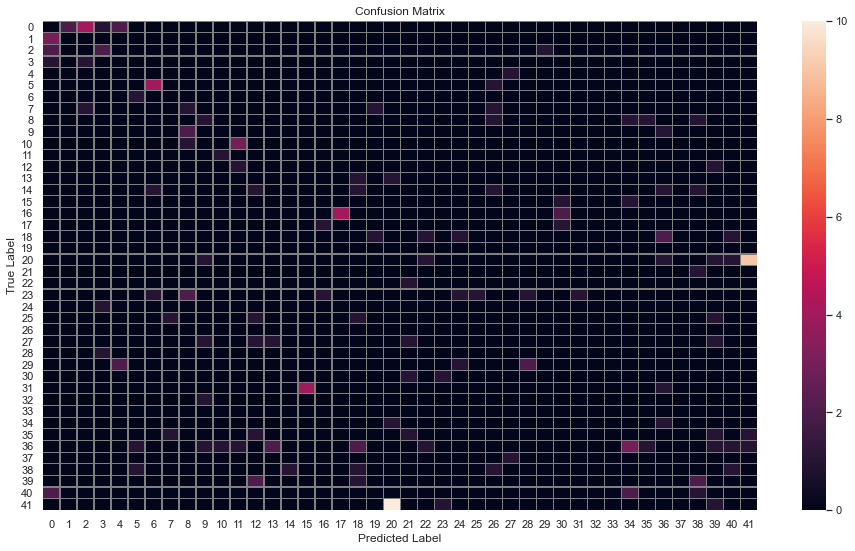

In [71]:
plt.figure(figsize = (16,9))
sns.heatmap(matrix_, linecolor='grey', linewidth=0.1)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig('confusion_matrix.png', 
            #transparent=True,
            bbox_inches='tight')

In [72]:
def label_smoother(x, alpha=0.1):
    return (1 - alpha) * x + alpha / x.shape[1]

In [73]:
loss     = tfk.losses.categorical_crossentropy(y_pred, label_smoother(y_true, alpha=0.1)).numpy().mean()
accuracy = accuracy_score(y_pred.argmax(axis=1), y_true.argmax(axis=1))

print("Loss:", loss)
print("Accuracy:", accuracy)

Loss: 1.1015037
Accuracy: 0.9475


## Generate Submission

### Prepare test data generator

In [74]:
pd_test = pd.read_csv('shopee-product-detection-dataset/test.csv')
pd_test.head()

,filename,category
0,fd663cf2b6e1d7b02938c6aaae0a32d2.jpg,43
1,c7fd77508a8c355eaab0d4e10efd6b15.jpg,43
2,127f3e6d6e3491b2459812353f33a913.jpg,43
3,5ca4f2da11eda083064e6c36f37eeb81.jpg,43
4,46d681a542f2c71be017eef6aae23313.jpg,43


In [75]:
test_datagen = tfk_ImageDataGenerator(
    preprocessing_function=tfk_preprocess_input
)

test_generator = test_datagen.flow_from_dataframe(
    pd_test,
    directory='shopee-product-detection-dataset/test/',
    x_col='filename',
    target_size=input_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode=None,
    shuffle=False,
)

Found 12186 validated image filenames.


### Predict categories

In [76]:
y_pred = model.predict(test_generator, verbose=1, steps=test_generator.n//batch_size+1)
y_pred = y_pred[:test_generator.n]

191/191 [==============================] - 57s 299ms/step


In [77]:
pd_submission = pd_test.copy()
pd_submission['category'] = list(map(lambda x : '{:02d}'.format(x), y_pred.argmax(axis=1)))
pd_submission.head()

,filename,category
0,fd663cf2b6e1d7b02938c6aaae0a32d2.jpg,20
1,c7fd77508a8c355eaab0d4e10efd6b15.jpg,27
2,127f3e6d6e3491b2459812353f33a913.jpg,04
3,5ca4f2da11eda083064e6c36f37eeb81.jpg,22
4,46d681a542f2c71be017eef6aae23313.jpg,12


In [78]:
pd_submission_ = pd_submission.drop(['category'], axis=1)
for c in range(42):
    pd_submission_[c] = y_pred[:,c]
pd_submission_.head()

,filename,0,1,2,3,4,5,6,7,8,...,32,33,34,35,36,37,38,39,40,41
0,fd663cf2b6e1d7b02938c6aaae0a32d2.jpg,0.001062,0.000684,0.000134,0.000199,0.000540,0.000284,0.000295,0.000402,0.000438,...,0.000095,0.000192,0.000609,0.000310,0.002228,0.000379,0.001500,0.001930,0.000345,0.051738
1,c7fd77508a8c355eaab0d4e10efd6b15.jpg,0.001451,0.001337,0.001185,0.000925,0.001583,0.001145,0.001150,0.001464,0.002079,...,0.000806,0.000773,0.001577,0.001187,0.000801,0.000818,0.000771,0.001410,0.000974,0.000545
2,127f3e6d6e3491b2459812353f33a913.jpg,0.001669,0.001508,0.002610,0.001780,0.900689,0.001427,0.001080,0.002460,0.003593,...,0.001229,0.001360,0.001246,0.001766,0.000828,0.001636,0.003009,0.001626,0.001489,0.004999
3,5ca4f2da11eda083064e6c36f37eeb81.jpg,0.001432,0.001434,0.001345,0.000857,0.001710,0.000863,0.001031,0.000886,0.001776,...,0.001504,0.001558,0.003291,0.001593,0.001262,0.001746,0.001101,0.001213,0.000730,0.000641
4,46d681a542f2c71be017eef6aae23313.jpg,0.002208,0.001831,0.001414,0.001491,0.003105,0.002208,0.002535,0.001520,0.001259,...,0.001109,0.002540,0.001707,0.006560,0.000566,0.001022,0.001550,0.004861,0.001709,0.001399


In [79]:
version = 28
pd_submission.to_csv('submission_{}.csv'.format(version), index=False)
pd_submission_.to_csv('submission_{}_dist.csv'.format(version), index=False)

### Compare to previous submission

In [80]:
now  = version
cat_now_name  = 'category_{}'.format(now)
prev = '27'
cat_prev_name = 'category_{}'.format(prev)

pd_submission_prev = pd.read_csv('submission_{}.csv'.format(prev))
pd_submission_prev['category'] = pd_submission_prev['category'].apply(lambda x : '{:02d}'.format(x))
pd_submission_prev.columns = ['filename', cat_prev_name]
pd_submission_prev = pd_submission_prev.merge(pd_submission.sort_values(by='filename'), on='filename')
pd_iba = pd_submission_prev[pd_submission_prev[cat_prev_name] != pd_submission_prev['category']]
print(len(pd_iba), len(pd_submission_prev), len(pd_iba) / len(pd_submission_prev))
pd_iba.head(20)

567 12186 0.0465288035450517


,filename,category_27,category
27,2e9521b6c76dd1d7bebbeb8a2d84cacc.jpg,14,38
33,26ef13b0da02bfa1ba211ee523b3fdbd.jpg,41,08
88,b00ec65ae02183e69f16e5a46d9d7973.jpg,26,19
91,5f6da1149fd4109457d375d70a8def4c.jpg,38,40
92,0f76078f68b2d6ae47e86ae488b6de08.jpg,00,02
123,835de04e18d0eff0774584a555e42a2a.jpg,33,35
159,805f92f1ddbd068096384d595596ffb9.jpg,12,34
223,2d5c4d3c9dcae43e0317e985e339db54.jpg,02,00
237,aca99804062a29a553c037c164a8c59b.jpg,38,07
243,3a3aa10a8b3640139ffaa19437509b2e.jpg,31,20


In [81]:
matrix = confusion_matrix(pd_submission_prev['category'], pd_submission_prev[cat_prev_name])
matrix_ = matrix.copy()
for i in range(len(matrix)):
    matrix_[i, i] = 0

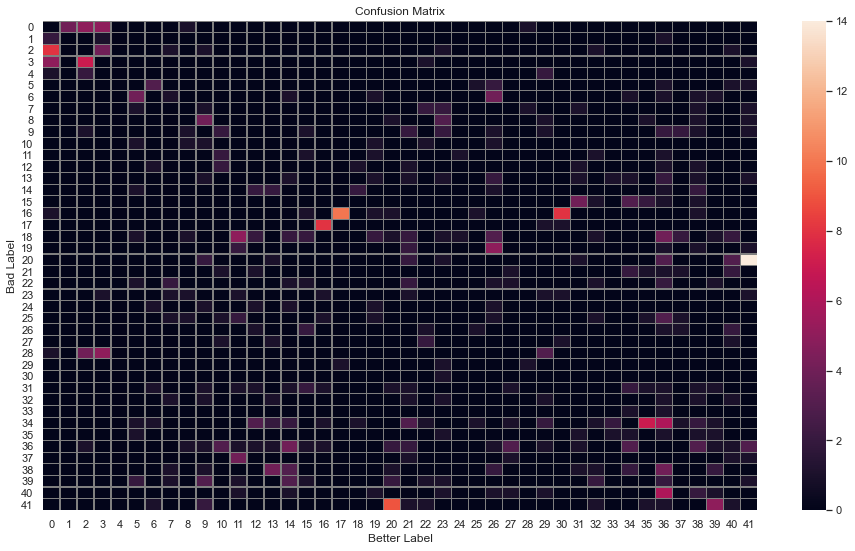

In [82]:
plt.figure(figsize = (16,9))
sns.heatmap(matrix_, linecolor='grey', linewidth=0.1)
plt.title("Confusion Matrix")
plt.xlabel("Better Label")
plt.ylabel("Bad Label")
plt.savefig('confusion_matrix.png', 
            #transparent=True,
            bbox_inches='tight')

In [83]:
pd_iba.to_csv("iba.csv", index=False)

In [84]:
pd_query = pd_submission_prev[(pd_submission_prev['category_{}'.format(prev)] == '20') & (pd_submission_prev['category'] == '41')]
print(len(pd_query), len(pd_query)/len(pd_submission_prev))
pd_query.head(20)

9 0.0007385524372230429


,filename,category_27,category
1952,a3ebc60c3f99cbdb957c0e66ce542661.jpg,20,41
3134,5b62c3aed0dcbfb0fea50041e9a232c8.jpg,20,41
3791,4f4ac25f31a06933a6d10f127b3a7778.jpg,20,41
6162,a6ffb9e99b156aed038f4023c458a279.jpg,20,41
8019,d8d36c64fbf062a251ed798391dd5099.jpg,20,41
8619,cb039abc1a4a814d074febda7fc72f88.jpg,20,41
10373,6de210cb997d6d05c73bbf59b22d54ff.jpg,20,41
10583,133bf282cd606e8866df945ce86ef3f9.jpg,20,41
11630,59b3b2b85afb42bb20d663f9dde07181.jpg,20,41


In [44]:
pd_query = pd_iba[(pd_iba['category_{}'.format(prev)] == '41') & (pd_iba['category'] == '20')]
print(len(pd_query), len(pd_query)/len(pd_submission_prev))
pd_query.head(20)

30 0.002461841457410143


,filename,category_25,category
419,41b8d6c7b78a01f77ed909c27c081794.jpg,41,20
1423,f95d477b242a327927d9ff5f8a72a9da.jpg,41,20
1598,0273cedf12ddeab3fdef5bb2dde65955.jpg,41,20
1944,89c9176f9bb746a60fb1d10a566c45b3.jpg,41,20
1952,a3ebc60c3f99cbdb957c0e66ce542661.jpg,41,20
2203,d881412afc4e613f8b28be4de46be149.jpg,41,20
2336,d50642fbb88ddd98719e0b3b5eaa6cdd.jpg,41,20
3004,c0ec76fd0d7bc7d2677481ea50b4e91f.jpg,41,20
3134,5b62c3aed0dcbfb0fea50041e9a232c8.jpg,41,20
3153,9e506bb1b5b8d2dc3348c92029df575e.jpg,41,20


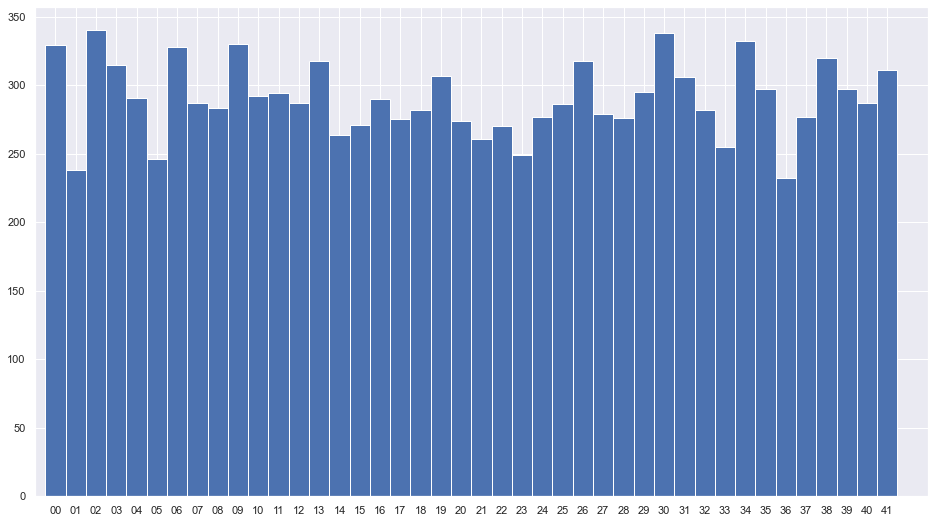

In [45]:
plt.figure(figsize=(16, 9))
plt.hist(pd_submission_prev['category'].sort_values(), bins=np.arange(-1, 43)-0.5)
plt.xlim(-1, 43)
plt.show()

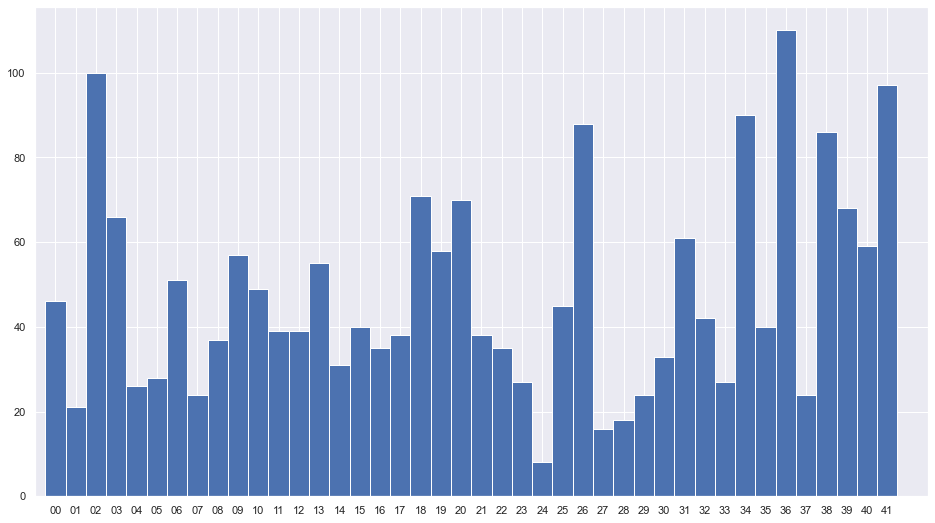

In [46]:
plt.figure(figsize=(16, 9))
plt.hist(pd_iba['category'].sort_values(), bins=np.arange(-1, 43)-0.5)
plt.xlim(-1, 43)
plt.show()